In [1]:
import os, random
random.seed(42)

In [2]:
file = os.listdir('datasets/kaist-rgbt/train/images/visible')
random.shuffle(file)
idx = 2000
valid = sorted(file[:idx])
train = sorted(file[idx:])

In [3]:
len(train), len(valid)

(10538, 2000)

In [3]:
dir = 'datasets/kaist-rgbt'
for typ in ['train', 'valid']:
    data = train if typ=='train' else valid
    with open(f'{dir}/{typ}.txt', 'w') as f:
        for file in data:
            f.write(f'{dir}/train/' + 'images/{}/' + file + '\n')

In [4]:
import yaml

with open('data/kaist-rgbt.yaml') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)
    categories_dict = dict((v,k) for k, v in data['names'].items())
categories_dict
ignores = [categories_dict[ignore] for ignore in []]
categories_dict, ignores

({'person': 0, 'cyclist': 1, 'people': 2, 'person?': 3}, [])

In [5]:
import xml.etree.ElementTree as ET
import json

path = f'{dir}/train/labels-xml'

def extract_label(data, path=path):
    images = []
    annotations = []

    anno_id = 0
    for img_id, file in enumerate(data):
        name = file.split('.')[0]
        file = f'{path}/{name}.xml'
        tree = ET.parse(file)
        filename = tree.find('filename').text
        height = int(tree.find('size').find('height').text)
        width = int(tree.find('size').find('width').text)
        objects = tree.findall('object')
        img = {"id": img_id,
            "im_name": filename,
            "height": height,
            "width": width}
        images += [img]
        for object in objects:
            category_id = categories_dict[object.find('name').text]
            bndbox = [int(object.find('bndbox').find('x').text),
                    int(object.find('bndbox').find('y').text),
                    int(object.find('bndbox').find('w').text),
                    int(object.find('bndbox').find('h').text)]
            height = bndbox[-1]
            occlusion = int(object.find('occlusion').text)
            ignore = 0 if category_id not in ignores else 1
            annotation = {"id": anno_id,
                        "image_id": img_id,
                        "category_id": category_id,
                        "bbox": bndbox,
                        "height": height,
                        "occlusion": occlusion,
                        "ignore": ignore}
            annotations += [annotation]
            anno_id += 1

    return images, annotations

def extract_categries(categories_dict):
    categories = []
    categories_dict['__ignore__'] = -1
    for name, id in categories_dict.items():
        categories += [{"id": id+1,
                    "name": name}]
    categories.sort(key = lambda x: x['id'])
    return categories

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def box_iou_wh(wh1, wh2):
    inter_section = np.minimum(wh1, wh2)
    inter_area = np.prod(inter_section, axis=-1)
    union_area = np.prod(wh1, axis=-1) + np.prod(wh2, axis=-1) - inter_area
    return inter_area / (union_area + 1e-6)

def kmeans(wh, k):
    np.random.seed(42)
    np.random.shuffle(wh)
    n = wh.shape[0]
    last_cluster = np.zeros((n,), dtype=np.int64)
    clusters = wh[:k]

    while True:
        distances = 1 - box_iou_wh(wh[:, None], clusters)
        nearest = np.argmin(distances, axis=1)
        if np.all(last_cluster == nearest):
            break
        for idx in range(k):
            clusters[idx] = np.mean(wh[nearest == idx], axis=0)

        last_cluster = nearest
        
    prod = np.prod(clusters, axis=-1)
    idx = np.argsort(prod)
    return clusters[idx]

def ransac(wh, k, th=0.5, time=500):
    np.random.seed(42)
    inliner = wh[:k].copy()
    for i in range(time):
        np.random.shuffle(wh)
        clusters = wh[:k]
        distances = 1 - box_iou_wh(wh[:, None], clusters)
        min_distances = np.min(distances, -1)
        temp = wh[min_distances < th]
        if inliner.shape[0] < temp.shape[0]:
            inliner = temp.copy()
    print(f'{inliner.shape[0]/wh.shape[0]*100:.2f}%')
    return inliner

def draw_anchor(anchors, img_size=416):
    np.random.seed(42)
    bg = np.zeros((img_size, img_size, 3), np.uint8) + 255
    c = np.array(bg.shape[:2])//2
    def draw_box(a):
        p1, p2, = c - a//2, c + a//2
        cv2.rectangle(bg, p1, p2, [np.random.randint(0, 255) for x in range(3)], 2)
    for anchor in anchors:
        for i in range(len(anchor)//2):
            draw_box(anchor[i*2:(i+1)*2])
    plt.imshow(bg)
    plt.show()

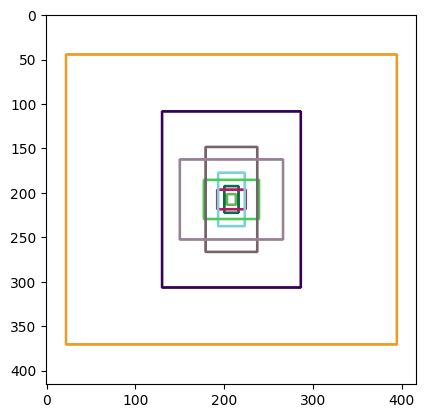

In [7]:
anchors = np.array([[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]])
draw_anchor(anchors)

99.03%
[[ 22  43  25  57  47  50]
 [ 33  74  42  91  47 115]
 [ 61 141 181  54  80 202]]


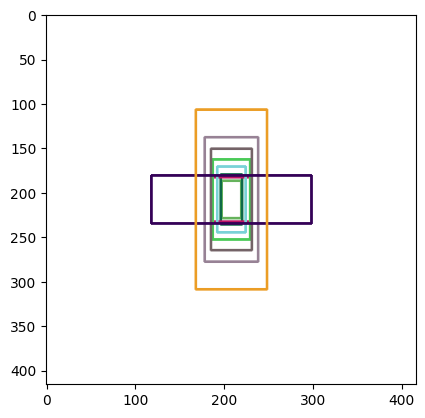

In [8]:
# train data
images, annotations = extract_label(train)

whs = []
for annotation in annotations:
    whs += [annotation['bbox'][2:]]

inliner = ransac(np.array(whs)/640, 10, 0.5)
anchors = np.ceil(kmeans(inliner, 9) * 640).astype(np.int32).reshape((3,6))
print(anchors)
draw_anchor(anchors)

In [9]:
anno = [[] for _ in range(len(categories_dict.values()))]
for i, annotation in enumerate(annotations):
    anno[annotation['category_id']] += [annotation['bbox'][2:]]

for i, bboxes in enumerate(anno):
    print(f'category_id {i}, {len(bboxes)}')

category_id 0, 8699
category_id 1, 1056
category_id 2, 1203
category_id 3, 190


In [10]:
import random
m = min([len(l) for l in anno[:-1]])
sq_whs = []
for a in anno[:-1]:
    sq_whs += [*random.sample(a, k=m)]

len(sq_whs)

3168

99.37%
[[ 23  45  43  44  30  63]
 [ 41  79  45 101 102  51]
 [ 59 125 211  56  82 188]]


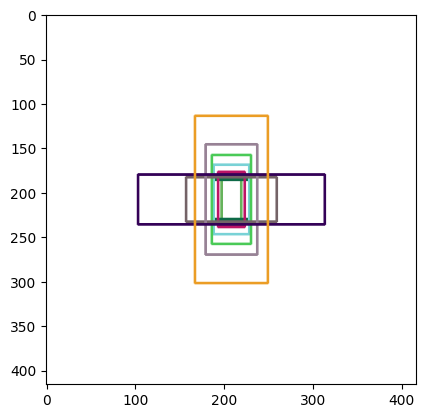

In [11]:
inliner = ransac(np.array(sq_whs)/640, 10, 0.5)
anchors = np.ceil(kmeans(inliner, 9) * 640).astype(np.int32).reshape((3,6))
print(anchors)
draw_anchor(anchors)

In [12]:
# valid data
images, annotations = extract_label(valid)
categories = extract_categries(categories_dict)

data = {"images": images,
        "annotations": annotations,
        "categories": categories}

json_file = 'utils/eval/KAIST_annotation.json'
anno_dir = 'datasets/kaist-rgbt/annotations'
# ex = f'{anno_dir}/instances_val2017.json'
if not os.path.exists(anno_dir):
    os.makedirs(anno_dir)
with open(json_file, 'w') as f:
    json.dump(data, f, indent=2)
# with open(ex, 'w') as f:
#     json.dump(data, f, indent=2)